### Contents

- [Header](#Header)
- [Import Data](#Import-Data)
- [Functions](#Functions)


- [Pre-process Data](#Pre-process-Data)
- [Plot df_model](#Plot-df_model)


- [Create Features and Target](#Create-Features-and-Target)
- [Handle Imbalanced Data](#Handle-Imbalanced-Data)


- [Logistic Regression Model](#Logistic-Regression-Model)
- [KNN Model](#KNN-Model)
- [DTC Model](#DTC-Model)
- [RTC Model](#RTC-Model)
- [SVC Model](#SVC-Model)
- [GridSearch Model](#GridSearch-Model)

### Header

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydotplus

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix,accuracy_score,r2_score,mean_squared_error,cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.externals.six import StringIO
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# file paths

raw_path = '../../data/0_raw/fitrec/' 
input_path = '../../data/1_input/fitrec/'
clean_path = '../../data/2_clean/fitrec/' 
preprocess_path = '../../data/3_preprocess/fitrec/' 
output_path = '../../data/4_output/fitrec/'

sports_path = '../../data/1_input/sports/' 

### Import Data

In [3]:
# import summary csv

#file = 'endomondoHR_proper_summary.csv'
#file = 'endomondoHR_proper_dist_spd_summary.csv'
file = 'endomondoHR_proper_dist_spd_time_summary.csv'

in_path = clean_path + file

df = pd.read_csv(in_path)
df.columns

Index(['id', 'userId', 'gender', 'sport', 'url', 'time_start', 'time_end',
       'time_dur', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 'alt_avg',
       'alt_min', 'alt_05', 'alt_25', 'alt_75', 'alt_95', 'alt_max',
       'alt_diff', 'hr_avg', 'hr_min', 'hr_05', 'hr_25', 'hr_75', 'hr_95',
       'hr_max', 'hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak', 'spd_avg',
       'spd_min', 'spd_05', 'spd_25', 'spd_75', 'spd_95', 'spd_max', 'spd_low',
       'spd_med', 'spd_high', 'spd_vhigh', 'impute'],
      dtype='object')

In [4]:
# import sports.xlsx

path = sports_path + 'sports.xlsx'
df_sports = pd.read_excel(path)
df_sports

,sport,sport_rename,type,venue,location_valid,distance_valid,speed_valid,speed_max
0,aerobics,aerobics,gym,indoor,0,0,0,0
1,badminton,badminton,racket,indoor,0,1,0,0
2,basketball,basketball,team,outdoor/indoor,1,1,0,0
3,bike,bike,aerobic,outdoor,1,1,1,244
4,bike (transport),bike,aerobic,outdoor,1,1,1,244
5,indoor cycling,bike,aerobic,indoor,0,1,1,244
6,mountain bike,bike,aerobic,outdoor,1,1,1,244
7,circuit training,circuit training,aerobic,outdoor/indoor,0,0,0,0
8,climbing,climbing,aerobic,outdoor/indoor,1,0,0,0
9,core stability training,core stability training,indoor,indoor,0,0,0,0


### Functions

### Drop Rows

In [5]:
# drop rows with abnormal heartrate

before = len(df)
print('before:',before)

cond_1 = df['hr_min'] >= 40
cond_2 = df['hr_avg'] >= 50
cond_3 = df['hr_max'] >= 60

df = df[cond_1 & cond_2 & cond_3]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167783
after: 167046
drop: 737


In [6]:
# drop rows with abnormal workout duration

before = len(df)
print('before:',before)

# time_dur in minutes
time_dur_mask = df['time_dur'] < 24 * 60
df = df[time_dur_mask]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167046
after: 167042
drop: 4


In [7]:
# drop rows with abnormal altitude

before = len(df)
print('before:',before)

# altitude in metres
max_alt_mask = df['alt_max'] <= 4000 # below Mount Kinabalu
min_alt_mask = df['alt_min'] >= -30 # 10 storeys underground
df = df[max_alt_mask & min_alt_mask]

after = len(df)
print('after:',after)
drop = before - after
print('drop:',drop)

before: 167042
after: 159231
drop: 7811


In [8]:
# drop rows if speed is nan

# before = len(df)
# print('before:',before)

# df.dropna(subset=['spd_avg'],inplace=True)

# after = len(df)
# print('after:',after)
# drop = before - after
# print('drop:',drop)

### Select and Merge Sports

In [9]:
# print number of workouts per sport (after dropping rows)

df['sport'].value_counts()

bike                       67962
run                        67298
mountain bike              10283
bike (transport)            7162
indoor cycling              1628
walk                        1222
orienteering                 849
cross-country skiing         781
core stability training      435
fitness walking              275
skate                        246
roller skiing                237
hiking                       232
kayaking                      89
circuit training              86
rowing                        70
weight training               69
gymnastics                    66
soccer                        51
downhill skiing               43
treadmill running             27
snowshoeing                   16
swimming                      13
golf                          12
elliptical                    10
horseback riding              10
badminton                      9
tennis                         8
basketball                     8
aerobics                       7
climbing  

In [10]:
# select only sports with speed_valid = 1

valid_mask = df_sports['speed_valid'] == 1
valid_sport_list = df_sports[valid_mask]['sport']
valid_sport_list = list(valid_sport_list)

# overwrite: compare specific sports
#valid_sport_list = ['kayaking','rowing']

valid_mask_2 = df['sport'].isin(valid_sport_list)
df = df[valid_mask_2]
df['sport'].unique()

array(['bike', 'bike (transport)', 'run', 'mountain bike', 'rowing',
       'orienteering', 'kayaking', 'indoor cycling', 'skate',
       'cross-country skiing', 'walk', 'hiking', 'treadmill running',
       'snowshoeing', 'snowboarding', 'fitness walking', 'roller skiing',
       'horseback riding', 'downhill skiing', 'swimming',
       'treadmill walking', 'sailing', 'kite surfing', 'windsurfing'],
      dtype=object)

In [11]:
# merge similar sports

for idx,row in df_sports.iterrows():
    
    sport = row['sport'].rstrip()
    sport_rename = row['sport_rename']
    print(sport,sport_rename)
    
    df['sport'].replace(sport,sport_rename,inplace=True)

aerobics aerobics
badminton badminton
basketball basketball
bike bike
bike (transport) bike
indoor cycling bike
mountain bike bike
circuit training circuit training
climbing climbing
core stability training core stability training
elliptical elliptical
golf golf
gymnastics gymnastics
hiking hiking
horseback riding horseback riding
kayaking kayaking
martial arts martial arts
orienteering orienteering
rowing rowing       
rugby rugby
run run
treadmill running run
sailing sailing
skate skate
cross-country skiing skiing
downhill skiing skiing
roller skiing skiing
snowboarding snowboarding
snowshoeing snowshoeing
soccer soccer
squash squash
stair climing stair climbing
kite surfing surfing
windsurfing surfing
swimming swimming
table tennis table tennis
tennis tennis
fitness walking walk
treadmill walking walk
walk walk
weight training weight training
pilates yoga
yoga yoga


In [12]:
# print number of workouts per sport (after selecting and merging sports)

df['sport'].value_counts()

bike                87035
run                 67325
walk                 1498
skiing               1061
orienteering          849
skate                 246
hiking                232
kayaking               89
rowing                 70
snowshoeing            16
swimming               13
horseback riding       10
snowboarding            3
surfing                 2
sailing                 1
Name: sport, dtype: int64

### Select Features

In [13]:
# feature selection (select columns for df_model)

# cols = ['sport','time_dur','alt_avg','alt_min','alt_25','alt_75','alt_max','hr_avg', 'hr_min','hr_25','hr_75','hr_max']

#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max']
#cols = ['sport','hr_avg','hr_min','hr_05','hr_25','hr_75','hr_95','hr_max']
#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max','spd_avg']
#cols = ['sport','hr_avg','hr_min','hr_25','hr_75','hr_max','spd_avg','spd_min','spd_25','spd_75','spd_max']

#cols = ['sport','spd_avg']
#cols = ['sport','spd_avg','spd_95']
#cols = ['sport','spd_avg','spd_05','spd_25','spd_75','spd_95']

#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_95']
#cols = ['sport','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_95']
cols = ['sport','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_95']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_25','spd_75']
#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_avg','spd_min','spd_25','spd_75','spd_max']

#cols = ['sport','hr_outof','hr_fatburn','hr_cardio','hr_peak','spd_low','spd_med','spd_high','spd_vhigh']

df_model = df[cols]

In [14]:
# select only sports with minimal rows

count = df_model['sport'].value_counts()

#count_cond = count[count > 1].index
#count_cond = count[count >= 5].inde
#count_cond = count[count >= 10].index
count_cond = count[count >= 50].index
#count_cond = count[count >= 70].index
#count_cond = count[count >= 100].index
#count_cond = count[count >= 200].index
#count_cond = count[count >= 800].index
#count_cond = count[count >= 1500].index
#count_cond = count[count >= 70000].index

count_mask = df_model['sport'].isin(count_cond)
df_model = df_model[count_mask]

In [15]:
print(df_model.shape)
df_model.head()

(158405, 6)


,sport,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95
0,bike,0.008026,0.507878,0.484096,26.152328,41.02704
1,bike,0.011256,0.612177,0.376567,27.636272,43.17102
2,bike,0.085785,0.790413,0.123802,26.159896,39.83040
3,bike,0.031234,0.674708,0.294058,27.135904,42.42096
4,bike,0.005738,0.076230,0.918033,31.241183,46.51405


In [16]:
# print number of workout by sports (with minimal rows)

df_model['sport'].value_counts()

bike             87035
run              67325
walk              1498
skiing            1061
orienteering       849
skate              246
hiking             232
kayaking            89
rowing              70
Name: sport, dtype: int64

### Plot df_model

In [17]:
# order = df_model.groupby('sport')['hr_max'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_max',y='sport',order=order);

In [18]:
# order = df_model.groupby('sport')['hr_avg'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_avg',y='sport',order=order);

In [19]:
# order = df_model.groupby('sport')['hr_min'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_min',y='sport',order=order);

### Create Features and Target

In [20]:
df_model.head()

,sport,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95
0,bike,0.008026,0.507878,0.484096,26.152328,41.02704
1,bike,0.011256,0.612177,0.376567,27.636272,43.17102
2,bike,0.085785,0.790413,0.123802,26.159896,39.83040
3,bike,0.031234,0.674708,0.294058,27.135904,42.42096
4,bike,0.005738,0.076230,0.918033,31.241183,46.51405


In [21]:
# doing scaling and encoding before create X and y

cols = df_model.columns[1:]

ss = StandardScaler()
df_model[cols] = ss.fit_transform(df_model[cols])

le = LabelEncoder()
df_model['sport'] = le.fit_transform(df_model['sport'])

In [22]:
# create feature and target. next perform train_test_split

X = df_model.drop(columns='sport')
y = df_model['sport']

#le = LabelEncoder()
#y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,stratify=y,random_state=3050)

In [23]:
# ss = StandardScaler()
# ss.fit(X_train)

# X_train = ss.transform(X_train)
# X_test = ss.transform(X_test)

In [24]:
df_model.head()

,sport,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95
0,0,-0.751071,0.109732,0.654394,0.948678,1.182728
1,0,-0.739741,0.436342,0.316973,1.124650,1.347898
2,0,-0.478304,0.994482,-0.476190,0.949576,1.090540
3,0,-0.669661,0.632156,0.058064,1.065315,1.290114
4,0,-0.759099,-1.241957,2.016061,1.552134,1.605442


### Handle Imbalanced Data

In [25]:
# check before upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(110883, 5)
(47522, 5)
(110883,)
(47522,)


In [26]:
# check before upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 60924, 1: 163, 2: 62, 3: 594, 4: 49, 5: 47127, 6: 172, 7: 743, 8: 1049}

In [27]:
# sm = SMOTE(random_state=3050)
# X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [28]:
# get majority class index and row count

# sport_counts = df_model['sport'].value_counts()
# print(sport_counts)

# major_class_index = sport_counts.index[0]
# major_class_count = sport_counts.values[0]
# print(major_class_index,major_class_count)

In [29]:
# concatenate our training data back together

Xy_train = pd.concat([X_train, y_train], axis=1)

sport_counts = Xy_train['sport'].value_counts()
print(sport_counts)

print(Xy_train.shape)
Xy_train.head()

0    60924
5    47127
8     1049
7      743
3      594
6      172
1      163
2       62
4       49
Name: sport, dtype: int64
(110883, 6)


,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95,sport
124508,0.592657,0.373080,-0.838918,0.892324,0.449526,0
159550,1.217311,-0.145424,-0.864672,1.490039,0.925204,0
85115,1.243319,-0.861898,-0.864672,0.230398,0.885185,0
7886,-0.736719,-0.012171,0.763711,-1.005802,-0.983467,5
104905,0.100726,0.093449,-0.091263,0.965268,1.646294,0


In [30]:
# perform upsampling and downsampling

sample_size = 12000

df_all_sample = pd.DataFrame()

sport_list = df_model['sport'].unique()
sport_list

for sport in sport_list:
    
    cond = Xy_train['sport'] == sport
    df_sport = Xy_train[cond]
    
    # perform downsampling
    if sport_counts[sport] >= sample_size:    
        print('downsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=False,random_state=3050)
        
    # perform upsampling
    # sport_counts[sport] < sample_size: 
    else:
        print('upsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=True,random_state=3050)
        
    df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
    
X_train = df_all_sample.drop(columns='sport').values
y_train = df_all_sample['sport'].values

downsampling 0 60924
downsampling 5 47127
upsampling 4 49
upsampling 3 594
upsampling 2 62
upsampling 6 172
upsampling 7 743
upsampling 8 1049
upsampling 1 163


In [31]:
# # perform upsampling for minority classes

# df_all_sample = pd.DataFrame()

# sport_list = df_model['sport'].unique()

# for sport in sport_list:
    
#     if sport != major_class_index:
        
#         cond = df_model['sport'] == sport
#         df_sport = df_model[cond]
#         #print(sport,len(df_sport))
        
#         df_sample = df_sport.sample(major_class_count,replace=True,random_state=3050)
#         df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
        
# cond = df_model['sport'] == major_class_index
# df_top = df_model[cond]
# df_all_sample = pd.concat([df_all_sample, df_top], axis=0)

# X_train = df_all_sample.drop(columns='sport').values
# y_train = df_all_sample['sport'].values

In [32]:
# check after upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108000, 5)
(47522, 5)
(108000,)
(47522,)


In [33]:
# check after upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 12000,
 1: 12000,
 2: 12000,
 3: 12000,
 4: 12000,
 5: 12000,
 6: 12000,
 7: 12000,
 8: 12000}

In [34]:
# store predictions in df_pred

df_pred = pd.DataFrame()

### Logistic Regression Model

In [35]:
# init model

logreg = LogisticRegression()

In [36]:
# perform cross validation

score = cross_val_score(logreg,X,y,cv=5)
print('score:',score.mean(),score)

score: 0.9457215818541009 [0.94009595 0.94359573 0.95094852 0.94542298 0.94854473]


In [37]:
# fit model

logreg.fit(X_train, y_train)

# score model
print("train r2:",logreg.score(X_train, y_train))
print("test r2:",logreg.score(X_test, y_test))

train r2: 0.5150555555555556
test r2: 0.7327763982997348


rows:actual columns:predicted


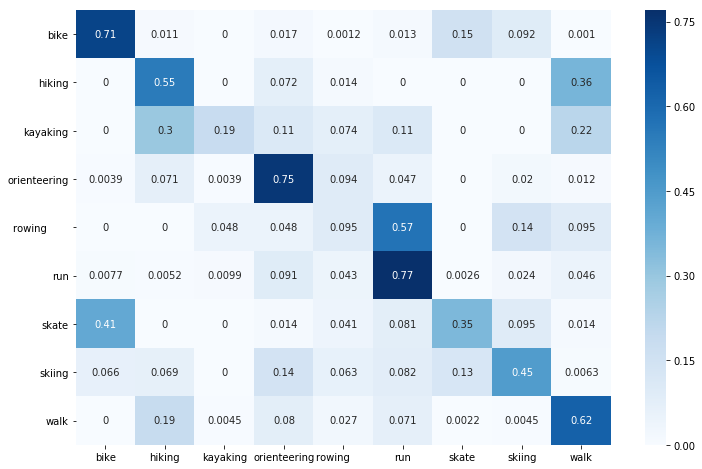

In [38]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = logreg.predict(X_test)
df_pred['lr'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_) 

### KNN Model

In [39]:
# init model

knn = KNeighborsClassifier(n_neighbors=3)

In [40]:
# perform cross validation

score = cross_val_score(knn,X,y,cv=5)
print('score:',score.mean(),score)

score: 0.9570277448892274 [0.96013761 0.95779938 0.9554307  0.95858586 0.95318518]


In [41]:
# fit model

knn.fit(X_train, y_train)

# score model
print("train r2:",knn.score(X_train, y_train))
print("test r2:",knn.score(X_test, y_test))

train r2: 0.9875092592592593
test r2: 0.9050965868439881


rows:actual columns:predicted


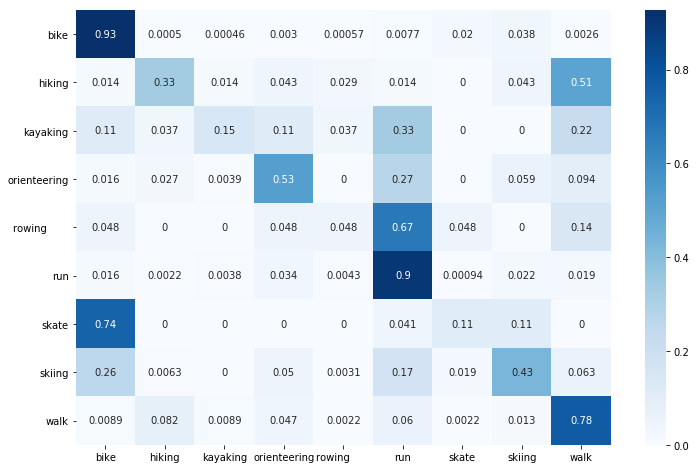

In [42]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = knn.predict(X_test)
df_pred['knn'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

# y_pred = knn.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

### DTC Model

In [43]:
# init model

dtc = DecisionTreeClassifier(max_depth=10,random_state=3050)

In [44]:
# perform cross validation

score = cross_val_score(dtc,X,y,cv=5)
print(score.mean(),score)

0.9593256722870773 [0.96212599 0.95928287 0.95786118 0.96164773 0.95571059]


In [45]:
# fit model
dtc = dtc.fit(X_train,y_train)

# score model
print("train r2:",dtc.score(X_train, y_train))
print("test r2:",dtc.score(X_test, y_test))

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

train r2: 0.846462962962963
test r2: 0.7391944783468709


rows:actual columns:predicted


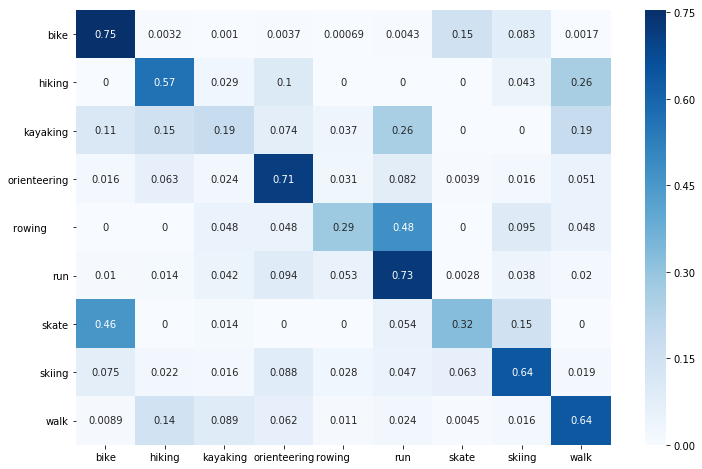

In [46]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = dtc.predict(X_test)
df_pred['dtc'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# y_pred = dtc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

In [47]:
# # initialize the output file object
# dot_data = StringIO() 

# # my fit DecisionTreeRegressor object here is: dtr1
# # for feature_names i put the columns of my Xr matrix
# export_graphviz(dtc, 
#                 out_file=dot_data,  
#                 filled=True, 
#                 rounded=True,
#                 special_characters=True,
#                 feature_names=df_model[features].columns
#                )  

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### RFC Model

In [48]:
# init model

rfc = RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=2, random_state=3050)

In [49]:
# perform cross validation

score = cross_val_score(rfc,X,y,cv=5)
print(score.mean(),score)

0.9628924934516905 [0.96559778 0.96237611 0.96152268 0.96515152 0.95981438]


In [50]:
# fit model
rfc = rfc.fit(X_train,y_train)

# score model
print("train r2:",rfc.score(X_train, y_train))
print("test r2:",rfc.score(X_test, y_test))

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

train r2: 0.9122592592592592
test r2: 0.8342031059298851


rows:actual columns:predicted


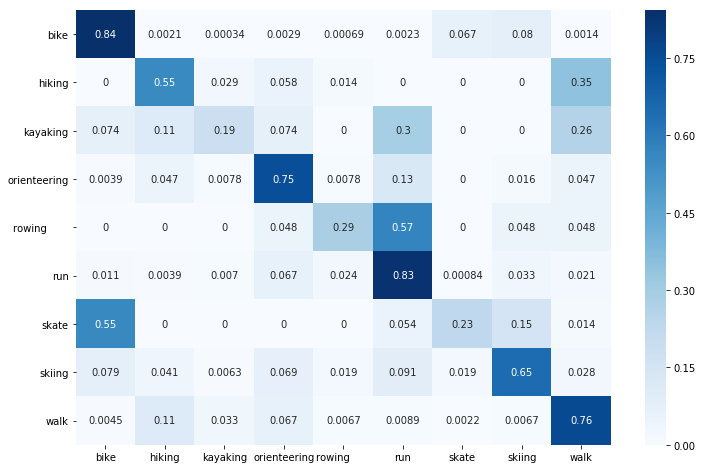

In [51]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = rfc.predict(X_test)
df_pred['rfc'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# y_pred = rfc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

### SVC Model

In [52]:
# init model

svc = SVC()

In [53]:
# fit model

svc.fit(X_train, y_train)

# score model
print("train r2:",svc.score(X_train, y_train))
print("test r2:",svc.score(X_test, y_test))

train r2: 0.7032222222222222
test r2: 0.7431084550313539


rows:actual columns:predicted


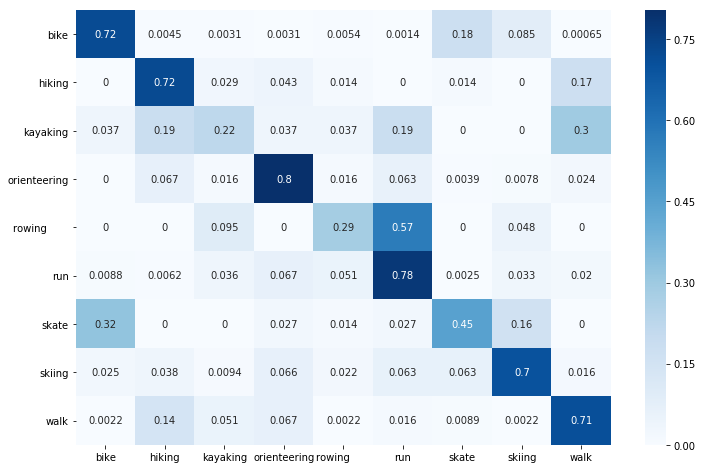

In [54]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = svc.predict(X_test)
df_pred['svc'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

### Combine Model Predictions

In [55]:
# check predictions

print(df_pred.shape)
df_pred.head()

(47522, 5)


,lr,knn,dtc,rfc,svc
0,5,5,5,5,5
1,8,8,8,8,8
2,0,0,0,0,0
3,1,4,1,1,8
4,5,5,5,5,5


In [56]:
cols = ['svc','rfc','dtc','lr','knn']
df_pred = df_pred[cols]

df_pred_mode = df_pred.mode(axis=1)
df_pred_mode.reset_index(inplace=True)

df_pred_final = df_pred_mode[0]

In [57]:
for idx,row in df_pred_mode.iterrows():
    
    if np.isnan(row[1]) == False:

        mode_list = list(row[1:])
        #print(mode_list)
        
        pred_row = df_pred.iloc[idx,:]
        #print(pred_row)
        
        
        for idx_2,cell in pred_row.iteritems():
            
            if cell in mode_list:
                #print(idx,idx_2,cell)
                df_pred_final[idx] = cell
                break

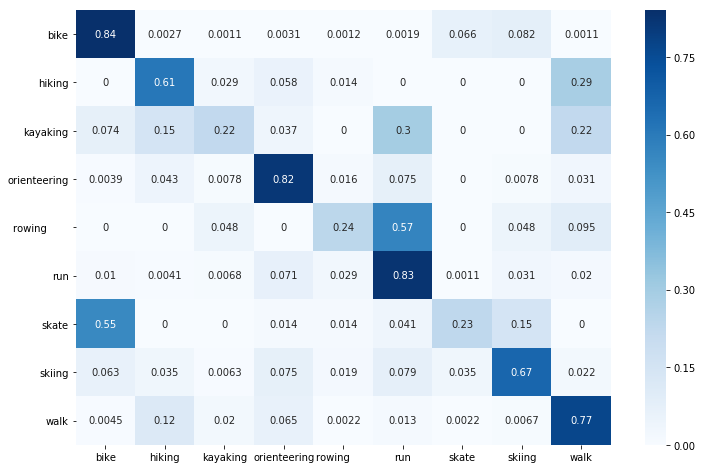

In [58]:
y_pred_final = df_pred_final.values

cm = confusion_matrix(y_test, y_pred_final)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### GridSearch Model

In [59]:
# init models

estimators = {
    'lr': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'abc': AdaBoostClassifier(),
    'gbc': GradientBoostingClassifier()
}.items()

In [60]:
# init model parameters

params = {
    'lr': {

    },
    'knn': {
        'knn__n_neighbors': [3,5,7,9]
    },

    'dtc': {
        'dtc__max_features': ['auto', 'log2', None],
        'dtc__max_depth': [None, 5, 10, 15],
        'dtc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'rfc': {
        'rfc__n_estimators': [10, 20, 50, 100],
        'rfc__max_depth': [None, 5, 10, 15],
        'rfc__max_features': ['auto', 'log2', None],
        'rfc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'abc': {

    }, 
    'gbc': {

    }
}

In [61]:
models = []
parameters = []
best_score = []
roc_auc = []

for k,v in estimators:
    
    pipe = Pipeline([
        ('sc', StandardScaler()),
        (k,v)])
    
    gridsearch = GridSearchCV(
        estimator=pipe,
        param_grid=params[k],
        verbose=1,
        cv= 5,
        n_jobs=-1,
        return_train_score= True
        #scoring = 'roc_auc'
    )

    gridsearch.fit(X_train, y_train)
    
    model = gridsearch.best_estimator_
    cv_score = gridsearch.cv_results_
    best_params = gridsearch.best_params_

    # predict y
    #y_pred = model.predict(X_test)
    y_pred = model.predict_proba(X_test)
    
    # print results
    print("Model: ", k)
    print("Best parameters:", best_params)
    print("Best score:", gridsearch.best_score_)
    #print("AUC/ROC test:", roc_auc_score(y_test,y_pred))
    display(pd.DataFrame(cv_score, columns = cv_score.keys()))    
    
    # append info to list
    models.append(k)
    best_score.append(gridsearch.best_score_)
    parameters.append(best_params)
    #roc_auc.append(roc_auc_score(y_test,y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished


Model:  lr
Best parameters: {}
Best score: 0.5148055555555555


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.324219,0.458076,0.014683,0.010052,{},0.513472,0.515046,0.519398,0.515833,0.510278,0.514806,0.002983,1,0.516956,0.515035,0.515231,0.513623,0.512801,0.514729,0.001432


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   44.4s finished


Model:  knn
Best parameters: {'knn__n_neighbors': 3}
Best score: 0.9775648148148148


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.477621,0.359306,1.518690,0.073861,3,{'knn__n_neighbors': 3},0.977361,0.977731,0.978148,0.977269,...,0.977565,0.000335,1,0.986516,0.985891,0.985880,0.985451,0.985938,0.985935,0.000340
1,1.115870,0.250716,1.262588,0.020710,5,{'knn__n_neighbors': 5},0.971343,0.972176,0.972685,0.971528,...,0.971861,0.000498,2,0.978368,0.978079,0.978079,0.978229,0.978484,0.978248,0.000160
2,0.952769,0.199200,1.339402,0.086128,7,{'knn__n_neighbors': 7},0.965880,0.966389,0.967917,0.965694,...,0.966537,0.000792,3,0.972292,0.972106,0.972211,0.972002,0.972512,0.972225,0.000173
3,1.195483,0.406907,1.920968,0.350242,9,{'knn__n_neighbors': 9},0.960972,0.961667,0.962269,0.960787,...,0.961556,0.000588,4,0.966817,0.966690,0.966609,0.966863,0.967049,0.966806,0.000151


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.3s finished


Model:  dtc
Best parameters: {'dtc__max_depth': None, 'dtc__max_features': None, 'dtc__min_samples_split': 0.1}
Best score: 0.5621388888888889


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtc__max_depth,param_dtc__max_features,param_dtc__min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.257512,0.011974,0.010172,1.934520e-03,None,auto,0.1,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.519676,0.546852,...,0.533713,0.011546,6,0.520394,0.545775,0.548542,0.518206,0.537743,0.534132,0.012638
1,0.210494,0.015584,0.010372,3.868297e-03,None,auto,0.2,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.476343,0.433056,...,0.441843,0.021757,22,0.478588,0.434317,0.436493,0.451539,0.415938,0.443375,0.020923
2,0.246002,0.052615,0.020543,1.075306e-02,None,auto,0.3,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.343287,0.353981,...,0.385009,0.030022,31,0.346516,0.355984,0.407697,0.402650,0.415069,0.385583,0.028468
3,0.197672,0.016753,0.015558,9.132518e-03,None,auto,0.4,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.366389,0.309815,...,0.313889,0.034962,45,0.367280,0.311690,0.335718,0.287789,0.266516,0.313799,0.035376
4,0.186500,0.015257,0.010971,5.498621e-03,None,auto,0.5,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.314213,0.287639,...,0.293454,0.020209,54,0.313032,0.288368,0.256597,0.295926,0.311493,0.293083,0.020486
5,0.290423,0.031211,0.011969,4.324101e-03,None,log2,0.1,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.542037,0.495926,...,0.531519,0.022935,7,0.547280,0.496076,0.515729,0.556956,0.547523,0.532713,0.023022
6,0.277259,0.038513,0.011170,3.645343e-03,None,log2,0.2,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.419398,0.473519,...,0.446426,0.022298,20,0.420579,0.474167,0.442975,0.426238,0.470880,0.446968,0.022152
7,0.245145,0.049019,0.008776,2.631928e-03,None,log2,0.3,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.336019,0.385000,...,0.354019,0.033763,35,0.335660,0.388495,0.361273,0.298171,0.386840,0.354088,0.033984
8,0.224000,0.010065,0.013764,6.256909e-03,None,log2,0.4,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.289213,0.302222,...,0.299704,0.022804,52,0.287975,0.302315,0.263634,0.301933,0.339931,0.299157,0.024767
9,0.183283,0.015025,0.014960,6.938837e-03,None,log2,0.5,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.256296,0.296157,...,0.281676,0.034609,57,0.256991,0.296123,0.311111,0.226667,0.317488,0.281676,0.034621


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 24.2min finished


Model:  rfc
Best parameters: {'rfc__max_depth': 15, 'rfc__max_features': 'auto', 'rfc__min_samples_split': 0.1, 'rfc__n_estimators': 10}
Best score: 0.5557777777777778


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_split,param_rfc__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.096919,0.049088,0.073602,0.008703,None,auto,0.1,10,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.559676,...,0.544333,0.009177,31,0.560359,0.545521,0.536111,0.542674,0.538403,0.544613,0.008525
1,2.294468,0.152710,0.120279,0.015121,None,auto,0.1,20,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.554028,...,0.552750,0.003361,13,0.561019,0.552396,0.555787,0.555035,0.546389,0.554125,0.004774
2,7.347163,0.520129,0.302192,0.039281,None,auto,0.1,50,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.556991,...,0.552009,0.003365,17,0.558067,0.550035,0.550880,0.550880,0.548819,0.551736,0.003254
3,13.654309,1.478622,0.711498,0.134210,None,auto,0.1,100,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.549120,...,0.554074,0.003306,10,0.551111,0.561192,0.554745,0.556470,0.548472,0.554398,0.004393
4,0.880846,0.112629,0.063630,0.012089,None,auto,0.2,10,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.449444,...,0.447222,0.019077,78,0.452813,0.468981,0.408160,0.453310,0.456655,0.447984,0.020754
5,1.557438,0.051211,0.111101,0.008093,None,auto,0.2,20,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.477361,...,0.467861,0.009197,65,0.479919,0.464618,0.459201,0.458229,0.481192,0.468632,0.009984
6,4.005494,0.264740,0.273271,0.014414,None,auto,0.2,50,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.478380,...,0.469731,0.014488,63,0.481227,0.454838,0.473565,0.451377,0.491840,0.470569,0.015433
7,7.025421,0.083254,0.503654,0.039763,None,auto,0.2,100,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.473935,...,0.474806,0.002788,57,0.476701,0.478229,0.473391,0.474375,0.471852,0.474910,0.002288
8,0.643080,0.027621,0.053657,0.002632,None,auto,0.3,10,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.415046,...,0.410583,0.009953,105,0.416528,0.417106,0.388194,0.412176,0.418750,0.410551,0.011387
9,1.162692,0.010713,0.104521,0.011239,None,auto,0.3,20,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.381389,...,0.403426,0.016039,140,0.381308,0.416400,0.422905,0.403507,0.391238,0.403072,0.015394


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


Model:  abc
Best parameters: {}
Best score: 0.3797962962962963


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.537853,1.11879,0.75239,0.156076,{},0.41662,0.414213,0.368935,0.323981,0.375231,0.379796,0.034043,1,0.419815,0.418704,0.367245,0.317639,0.380451,0.380771,0.037768


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


Model:  gbc
Best parameters: {}
Best score: 0.8844351851851852


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,147.833304,38.044923,0.443208,0.097807,{},0.879537,0.881991,0.886343,0.886852,0.887454,0.884435,0.003116,1,0.885336,0.888345,0.88897,0.889838,0.892211,0.88894,0.002229
